In [5]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
from sklearn.model_selection import train_test_split

In [6]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse

# Loading dataset

In [7]:
#No normalization is required
#Loading isolated pulses (not long traces)
df = pd.read_csv("../PeakDetection_Co60_IndividualPulses2kV_v4_t50.csv", index_col = 0)
df = df.T

In [8]:
df

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0        138   136   138   138   139   137   138   137   138   137  ...   137   
1        137   137   137   137   138   137   137   137   138   138  ...   137   
2        137   137   137   137   139   137   138   138   137   137  ...    96   
3         94   108   117   121   127   122   114   114   119   116  ...   137   
4        137   137   137   137   138   138   137   137   137   137  ...   138   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
220135   136   136   137   137   138   137   137   137   137   138  ...   137   
220136   137   136   137   137   138   136   137   138   138   137  ...   137   
220137   137   137   137   138   139   137   137   138   137   138  ...   136   
220138   137   137   137   137   138   137   137   137   138   137  ...   137   
220139   137   136   137   137   139   137   137   138   138   138  ...   137   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
0        136   138   137   137   137   137   138   137   136  
1        138   137   138   137   138   137   138   138   138  
2         93    90    88    88    89    99   107   112   117  
3        137   137   137   137   137   137   137   137   137  
4        137   137   139   137   137   137   137   137   137  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
220135   136   137   137   138   137   137   137   137   137  
220136   137   138   138   137   137   137   137   137   137  
220137   138   138   137   137   137   137   137   138   137  
220138   137   137   137   138   137   137   137   137   137  
220139   138   137   137   137   137   138   137   137   137  

[220140 rows x 1500 columns]

# Peak detection and valid pulse filtering algorithms

In [9]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

In [10]:
def validPulse(x, initThrs = 5, lookForPeakWindow = 10, windowSize = 200, thrshldRatios = 1.5):

    #Check if a high peak pulse is detected at the beginning
    
    partValid = 0
    for i in range(lookForPeakWindow):
        if x[i] > initThrs:
            partValid = 1
#             print("Valid initial peak")
            
    #Is this a decreasing "typical" pulse?
    if partValid:
        initAvg = sum(x[windowSize:]) / windowSize
        endAvg = sum(x[:windowSize]) / windowSize
#         print("Average ratios: " + str(initAvg / endAvg))
        if (initAvg / endAvg) > thrshldRatios:
            return 1
        
    return 0

        

# Filtering only valid typical pulses

### Remove baseline frist

In [11]:
df2 = pd.DataFrame()

In [12]:
for i in range(len(df.T)):
    df2[i] = df.max(axis = 1)[i] - df[i]
df2

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0          1     3     1     1     0     2     0     2     0     2  ...     1   
1          2     2     2     2     1     2     1     2     0     1  ...     1   
2          2     2     2     2     0     2     0     1     1     2  ...    42   
3         45    31    22    18    12    17    24    25    19    23  ...     1   
4          2     2     2     2     1     1     1     2     1     2  ...     0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
220135     3     3     2     2     1     2     1     2     1     1  ...     1   
220136     2     3     2     2     1     3     1     1     0     2  ...     1   
220137     2     2     2     1     0     2     1     1     1     1  ...     2   
220138     2     2     2     2     1     2     1     2     0     2  ...     1   
220139     2     3     2     2     0     2     1     1     0     1  ...     1   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
0          3     1     1     1     1     1     0     1     2  
1          1     2     0     1     0     1     0     0     0  
2         46    49    50    50    49    39    31    26    21  
3          2     2     1     1     1     1     1     1     1  
4          2     2    -1     1     1     1     1     1     1  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
220135     3     2     1     0     1     1     1     1     1  
220136     2     1     0     1     1     1     1     1     1  
220137     1     1     1     1     1     1     1     0     1  
220138     2     2     1     0     1     1     1     1     1  
220139     1     2     1     1     1     0     1     1     1  

[220140 rows x 1500 columns]

### Apply pulse validation algorithm

In [13]:
df2["ValidPulse"] = df2.apply(validPulse, axis = 1)
df2

0   1   2   3   4   5   6   7   8   9  ...  1491  1492  1493  1494  \
0        1   3   1   1   0   2   0   2   0   2  ...     3     1     1     1   
1        2   2   2   2   1   2   1   2   0   1  ...     1     2     0     1   
2        2   2   2   2   0   2   0   1   1   2  ...    46    49    50    50   
3       45  31  22  18  12  17  24  25  19  23  ...     2     2     1     1   
4        2   2   2   2   1   1   1   2   1   2  ...     2     2    -1     1   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
220135   3   3   2   2   1   2   1   2   1   1  ...     3     2     1     0   
220136   2   3   2   2   1   3   1   1   0   2  ...     2     1     0     1   
220137   2   2   2   1   0   2   1   1   1   1  ...     1     1     1     1   
220138   2   2   2   2   1   2   1   2   0   2  ...     2     2     1     0   
220139   2   3   2   2   0   2   1   1   0   1  ...     1     2     1     1   

        1495  1496  1497  1498  1499  ValidPulse  
0          1     1     0     1     2           0  
1          0     1     0     0     0           0  
2         49    39    31    26    21           0  
3          1     1     1     1     1           1  
4          1     1     1     1     1           0  
...      ...   ...   ...   ...   ...         ...  
220135     1     1     1     1     1           0  
220136     1     1     1     1     1           0  
220137     1     1     1     0     1           0  
220138     1     1     1     1     1           0  
220139     1     0     1     1     1           0  

[220140 rows x 1501 columns]

In [14]:
dfPulses = df2.loc[df2["ValidPulse"] > 0]
dfPulses = dfPulses.drop("ValidPulse", axis = 1)
dfPulses

0     1     2     3     4     5     6     7     8     9     ...  1490  \
3         45    31    22    18    12    17    24    25    19    23  ...     1   
6          7     5     6     3     2    11    14    15     9    10  ...     1   
7          6     3     3     3     1     2     2     2     1     2  ...     1   
12         4     9    13    11    12    26    31    25    20    22  ...     1   
15        15    11    10     8     4     5    13    19    17    21  ...     1   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
220082    18    15     9     8     5     5    12    16    10    10  ...     1   
220089    11     6     6     5     3     3     3    15    24    23  ...     0   
220118    16     8    11     7     2     5     3     2     3     4  ...     1   
220123     3     2     3     3     1     2     3    15    19    14  ...     1   
220129     3     2     3     2     1     3     1     2     8    23  ...     1   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
3          2     2     1     1     1     1     1     1     1  
6          2     2     2     0     1     0     1     1     0  
7          2     2     1     0     1     1     1     0     1  
12         2     1     1     0     1     1     2     0     1  
15         2     1     1     0     2     0     0     1     1  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
220082     3     2     1     1     0     0     1     0     1  
220089     2     2     1     0     1     1     1     1     0  
220118     2     1     1     0     1     2     1     1     1  
220123     2     2     1     1     1     1     1     0     1  
220129     1     2     1     1     1     1     1     0     0  

[35795 rows x 1500 columns]

# ===== DEBUGGING TEST - DO NOT RUN =======

In [22]:
%matplotlib notebook
dfPulses.iloc[1000:1010,:].T.plot()
plt.show()

TypeError: no numeric data to plot

In [ ]:
import random
randPulse = random.randrange(len(df2))
randPulse

In [ ]:
%matplotlib notebook
sample = df2.iloc[randPulse,:]
sample.plot()
plt.show()
print("Valid: "+ str(validPulse(sample, 5, 10, 200, 1.5)))

# ===== DEBUGGING ENDS HERE :) =======

# Peaks sequence detection

In [11]:
import random
randPulse = random.randrange(len(dfPulses))
randPulse

7334

In [12]:
# Peak time distribution
samplePulse = dfPulses.iloc[randPulse]
samplePulse = samplePulse[:800]
samplePulse["peakLocations"] = pkdetect(samplePulse, 2, 5)
# samplePulse

<IPython.core.display.Javascript object>


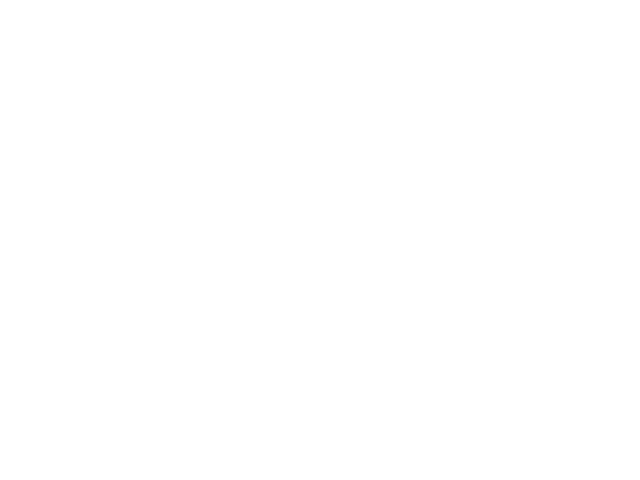

In [13]:
%matplotlib notebook
onlyPulse = samplePulse.iloc[:-1]
peaks = samplePulse.iloc[-1]
ax = onlyPulse.plot()
plt.plot(peaks, onlyPulse[peaks], 'r.')
plt.show()

In [22]:
a = dfPulses.iloc[:100].copy()
a["peakLocations"] = a.apply(pkdetect, args = (5, 5), axis = 1)
b = a.loc[a["peakLocations"].map(len) > 1]
#b[b.columns[:15]]
c = b.loc[:,"peakLocations"]
c

KeyError: 1500

In [15]:
#Add peak locations column to each pulse
dfPulses["peakLocations"] = dfPulses[dfPulses.columns[:PMT_PULSE_LENGTH]].apply(pkdetect, args = (2, 5), axis = 1)


#Remove pulses with less than 2 peaks
dfPulses = dfPulses.drop(dfPulses.loc[dfPulses["peakLocations"].map(len) < 2].T, axis = 0)
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1491  1492  1493  1494  \
3       45  31  22  18  12  17  24  25  19  23  ...     2     2     1     1   
6        7   5   6   3   2  11  14  15   9  10  ...     2     2     2     0   
7        6   3   3   3   1   2   2   2   1   2  ...     2     2     1     0   
12       4   9  13  11  12  26  31  25  20  22  ...     2     1     1     0   
15      15  11  10   8   4   5  13  19  17  21  ...     2     1     1     0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
220082  18  15   9   8   5   5  12  16  10  10  ...     3     2     1     1   
220089  11   6   6   5   3   3   3  15  24  23  ...     2     2     1     0   
220118  16   8  11   7   2   5   3   2   3   4  ...     2     1     1     0   
220123   3   2   3   3   1   2   3  15  19  14  ...     2     2     1     1   
220129   3   2   3   2   1   3   1   2   8  23  ...     1     2     1     1   

        1495  1496  1497  1498  1499  \
3          1     1     1     1     1   
6          1     0     1     1     0   
7          1     1     1     0     1   
12         1     1     2     0     1   
15         2     0     0     1     1   
...      ...   ...   ...   ...   ...   
220082     0     0     1     0     1   
220089     1     1     1     1     0   
220118     1     2     1     1     1   
220123     1     1     1     0     1   
220129     1     1     1     0     0   

                                            peakLocations  
3       [1, 7, 10, 23, 32, 38, 47, 51, 58, 69, 77, 81,...  
6       [7, 15, 25, 46, 83, 87, 90, 93, 103, 138, 202,...  
7       [185, 189, 238, 750, 931, 1056, 1146, 1296, 1303]  
12      [6, 10, 16, 36, 70, 92, 111, 203, 270, 361, 39...  
15      [1, 11, 20, 43, 53, 58, 80, 83, 86, 97, 112, 1...  
...                                                   ...  
220082  [1, 7, 32, 48, 171, 182, 235, 301, 337, 350, 3...  
220089  [8, 23, 45, 68, 77, 89, 127, 141, 171, 213, 24...  
220118  [2, 38, 55, 72, 76, 93, 108, 124, 132, 140, 17...  
220123  [8, 86, 129, 153, 186, 274, 288, 298, 318, 351...  
220129  [10, 110, 517, 545, 554, 642, 704, 752, 767, 8...  

[35661 rows x 1501 columns]

### Time between first and Nth peaks

In [16]:
def relativeArrivalTimes(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[0]) #Relative time respect to first peak
    
    return deltaList

### Time between successive peaks

In [17]:
def timeBetweenPeaks(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[i]) #Relative time respect to first peak
    
    return deltaList

In [18]:
dfPulses["arrivalTimes"] = dfPulses["peakLocations"].apply(relativeArrivalTimes)
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1492  1493  1494  1495  \
3       45  31  22  18  12  17  24  25  19  23  ...     2     1     1     1   
6        7   5   6   3   2  11  14  15   9  10  ...     2     2     0     1   
7        6   3   3   3   1   2   2   2   1   2  ...     2     1     0     1   
12       4   9  13  11  12  26  31  25  20  22  ...     1     1     0     1   
15      15  11  10   8   4   5  13  19  17  21  ...     1     1     0     2   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
220082  18  15   9   8   5   5  12  16  10  10  ...     2     1     1     0   
220089  11   6   6   5   3   3   3  15  24  23  ...     2     1     0     1   
220118  16   8  11   7   2   5   3   2   3   4  ...     1     1     0     1   
220123   3   2   3   3   1   2   3  15  19  14  ...     2     1     1     1   
220129   3   2   3   2   1   3   1   2   8  23  ...     2     1     1     1   

        1496  1497  1498  1499  \
3          1     1     1     1   
6          0     1     1     0   
7          1     1     0     1   
12         1     2     0     1   
15         0     0     1     1   
...      ...   ...   ...   ...   
220082     0     1     0     1   
220089     1     1     1     0   
220118     2     1     1     1   
220123     1     1     0     1   
220129     1     1     0     0   

                                            peakLocations  \
3       [1, 7, 10, 23, 32, 38, 47, 51, 58, 69, 77, 81,...   
6       [7, 15, 25, 46, 83, 87, 90, 93, 103, 138, 202,...   
7       [185, 189, 238, 750, 931, 1056, 1146, 1296, 1303]   
12      [6, 10, 16, 36, 70, 92, 111, 203, 270, 361, 39...   
15      [1, 11, 20, 43, 53, 58, 80, 83, 86, 97, 112, 1...   
...                                                   ...   
220082  [1, 7, 32, 48, 171, 182, 235, 301, 337, 350, 3...   
220089  [8, 23, 45, 68, 77, 89, 127, 141, 171, 213, 24...   
220118  [2, 38, 55, 72, 76, 93, 108, 124, 132, 140, 17...   
220123  [8, 86, 129, 153, 186, 274, 288, 298, 318, 351...   
220129  [10, 110, 517, 545, 554, 642, 704, 752, 767, 8...   

                                             arrivalTimes  
3       [6, 9, 22, 31, 37, 46, 50, 57, 68, 76, 80, 92,...  
6       [8, 18, 39, 76, 80, 83, 86, 96, 131, 195, 199,...  
7                 [4, 53, 565, 746, 871, 961, 1111, 1118]  
12      [4, 10, 30, 64, 86, 105, 197, 264, 355, 384, 4...  
15      [10, 19, 42, 52, 57, 79, 82, 85, 96, 111, 117,...  
...                                                   ...  
220082  [6, 31, 47, 170, 181, 234, 300, 336, 349, 398,...  
220089  [15, 37, 60, 69, 81, 119, 133, 163, 205, 239, ...  
220118  [36, 53, 70, 74, 91, 106, 122, 130, 138, 168, ...  
220123  [78, 121, 145, 178, 266, 280, 290, 310, 343, 3...  
220129  [100, 507, 535, 544, 632, 694, 742, 757, 889, ...  

[35661 rows x 1502 columns]

In [19]:
dfPulses["timeBetweenPeaks"] = dfPulses["peakLocations"].apply(timeBetweenPeaks)
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1493  1494  1495  1496  \
3       45  31  22  18  12  17  24  25  19  23  ...     1     1     1     1   
6        7   5   6   3   2  11  14  15   9  10  ...     2     0     1     0   
7        6   3   3   3   1   2   2   2   1   2  ...     1     0     1     1   
12       4   9  13  11  12  26  31  25  20  22  ...     1     0     1     1   
15      15  11  10   8   4   5  13  19  17  21  ...     1     0     2     0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
220082  18  15   9   8   5   5  12  16  10  10  ...     1     1     0     0   
220089  11   6   6   5   3   3   3  15  24  23  ...     1     0     1     1   
220118  16   8  11   7   2   5   3   2   3   4  ...     1     0     1     2   
220123   3   2   3   3   1   2   3  15  19  14  ...     1     1     1     1   
220129   3   2   3   2   1   3   1   2   8  23  ...     1     1     1     1   

        1497  1498  1499                                      peakLocations  \
3          1     1     1  [1, 7, 10, 23, 32, 38, 47, 51, 58, 69, 77, 81,...   
6          1     1     0  [7, 15, 25, 46, 83, 87, 90, 93, 103, 138, 202,...   
7          1     0     1  [185, 189, 238, 750, 931, 1056, 1146, 1296, 1303]   
12         2     0     1  [6, 10, 16, 36, 70, 92, 111, 203, 270, 361, 39...   
15         0     1     1  [1, 11, 20, 43, 53, 58, 80, 83, 86, 97, 112, 1...   
...      ...   ...   ...                                                ...   
220082     1     0     1  [1, 7, 32, 48, 171, 182, 235, 301, 337, 350, 3...   
220089     1     1     0  [8, 23, 45, 68, 77, 89, 127, 141, 171, 213, 24...   
220118     1     1     1  [2, 38, 55, 72, 76, 93, 108, 124, 132, 140, 17...   
220123     1     0     1  [8, 86, 129, 153, 186, 274, 288, 298, 318, 351...   
220129     1     0     0  [10, 110, 517, 545, 554, 642, 704, 752, 767, 8...   

                                             arrivalTimes  \
3       [6, 9, 22, 31, 37, 46, 50, 57, 68, 76, 80, 92,...   
6       [8, 18, 39, 76, 80, 83, 86, 96, 131, 195, 199,...   
7                 [4, 53, 565, 746, 871, 961, 1111, 1118]   
12      [4, 10, 30, 64, 86, 105, 197, 264, 355, 384, 4...   
15      [10, 19, 42, 52, 57, 79, 82, 85, 96, 111, 117,...   
...                                                   ...   
220082  [6, 31, 47, 170, 181, 234, 300, 336, 349, 398,...   
220089  [15, 37, 60, 69, 81, 119, 133, 163, 205, 239, ...   
220118  [36, 53, 70, 74, 91, 106, 122, 130, 138, 168, ...   
220123  [78, 121, 145, 178, 266, 280, 290, 310, 343, 3...   
220129  [100, 507, 535, 544, 632, 694, 742, 757, 889, ...   

                                         timeBetweenPeaks  
3       [6, 3, 13, 9, 6, 9, 4, 7, 11, 8, 4, 12, 6, 12,...  
6       [8, 10, 21, 37, 4, 3, 3, 10, 35, 64, 4, 29, 14...  
7                      [4, 49, 512, 181, 125, 90, 150, 7]  
12      [4, 6, 20, 34, 22, 19, 92, 67, 91, 29, 96, 71,...  
15      [10, 9, 23, 10, 5, 22, 3, 3, 11, 15, 6, 6, 9, ...  
...                                                   ...  
220082  [6, 25, 16, 123, 11, 53, 66, 36, 13, 49, 93, 8...  
220089  [15, 22, 23, 9, 12, 38, 14, 30, 42, 34, 8, 9, ...  
220118  [36, 17, 17, 4, 17, 15, 16, 8, 8, 30, 5, 9, 19...  
220123  [78, 43, 24, 33, 88, 14, 10, 20, 33, 41, 52, 1...  
220129  [100, 407, 28, 9, 88, 62, 48, 15, 132, 25, 9, ...  

[35661 rows x 1503 columns]

## Relative time between first and Nth peak

<IPython.core.display.Javascript object>


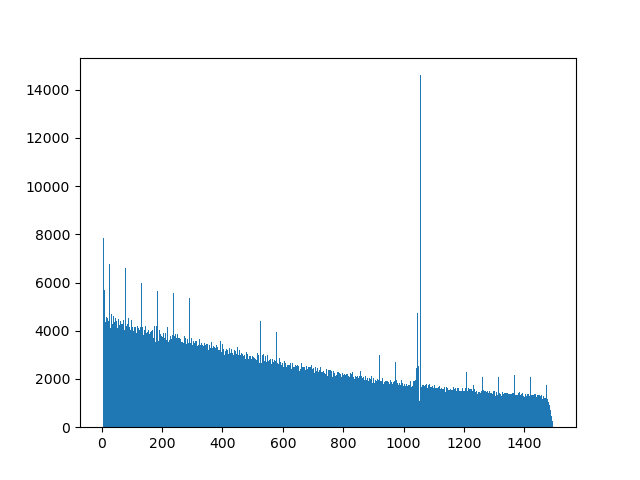

In [41]:
%matplotlib notebook
arrivalTimes = []
for i in dfPulses["arrivalTimes"]:
    arrivalTimes.extend(i)

nBinsFit = int(2*(len(arrivalTimes)**(2/5.0)))
# nBinsFit = 149
    
histData = plt.hist(arrivalTimes, bins = nBinsFit)
plt.show()

In [42]:
nBinsFit

648

# Model fitting
## Finding parameters of exponential distribution for relative times from first peak

In [43]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [44]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [45]:
fittingBoundsAmp = (1000, 80000)
fittingBoundsLam = (1e-6, 1.00)

In [46]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [47]:
distAmp

5284.627231874172

In [48]:
distLambda

0.0008885240743204659

<IPython.core.display.Javascript object>


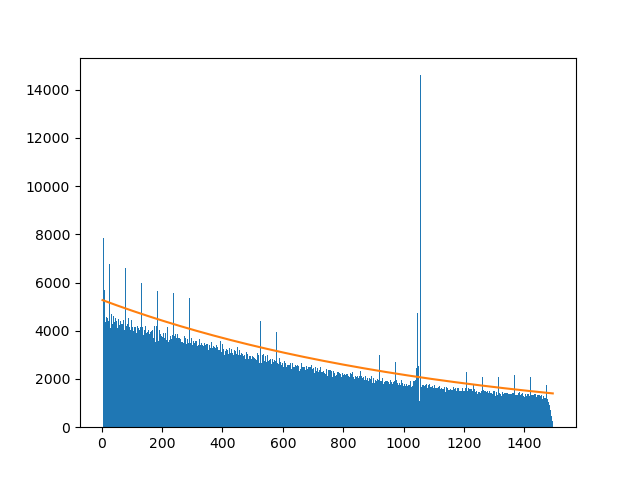

In [49]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(arrivalTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

## Finding parameters of exponential distribution for time between succesive peaks (Poisson)

<IPython.core.display.Javascript object>


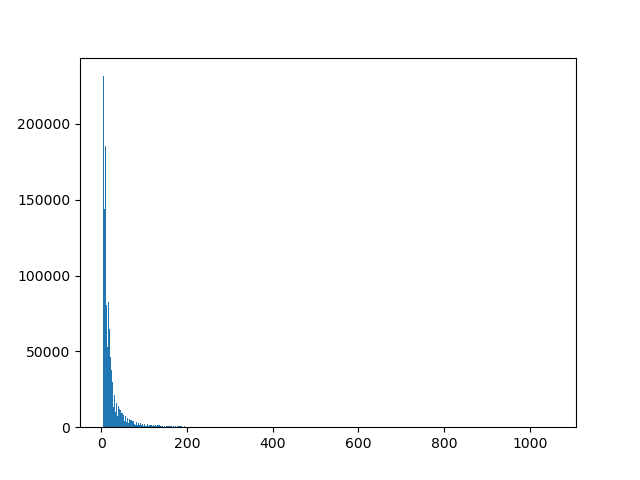

In [50]:
%matplotlib notebook
betweenPulsesTimes = []
for i in dfPulses["timeBetweenPeaks"]:
    betweenPulsesTimes.extend(i)

nBinsFit = int(2*(len(betweenPulsesTimes)**(2/5.0)))
    
histData = plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.show()

In [51]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [52]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [53]:
fittingBoundsAmp = (2000, 380000)
fittingBoundsLam = (1e-9, 1.00)

In [54]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [55]:
distAmp

297676.19915803254

In [56]:
distLambda

0.08577829006758601

<IPython.core.display.Javascript object>


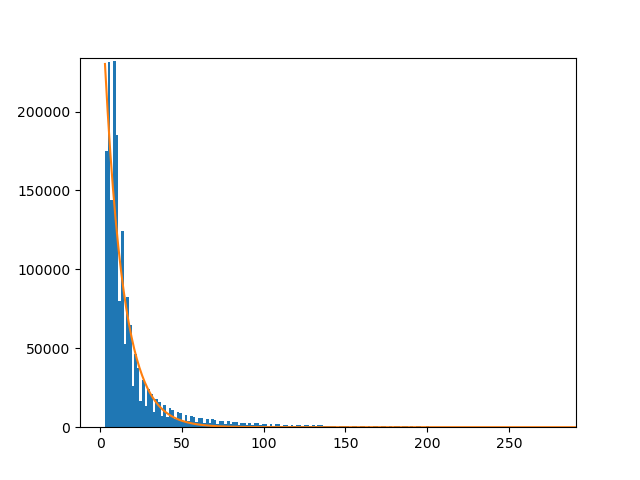

In [57]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

# Determining pulse waveform of arrivalTimes artifact at sample #590

In [165]:
len(dfPulses)

3836

In [166]:
# regionOfInterest = range(588, 593)
regionOfInterest = range(440, 470)
pulseIndexes = []

#Filtering only "wierd" pulses from the dataset
for i in range(len(dfPulses)):
    for j in dfPulses["arrivalTimes"].iloc[i]:
        if j in regionOfInterest:
            pulseIndexes.append(i)
            break

<IPython.core.display.Javascript object>


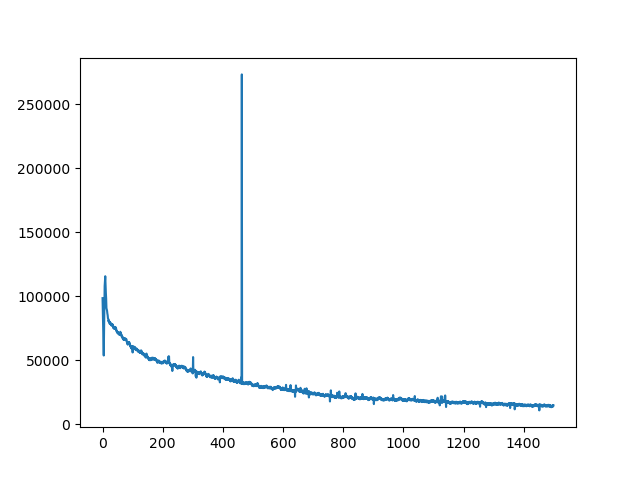

In [147]:
#Summing up "sample by sample" all the pulses contribution

%matplotlib notebook
wierdPulses = dfPulses.iloc[pulseIndexes[:]]
wierdPulses = wierdPulses.sum()
plt.plot(wierdPulses[:PMT_PULSE_LENGTH])
plt.show()

<IPython.core.display.Javascript object>


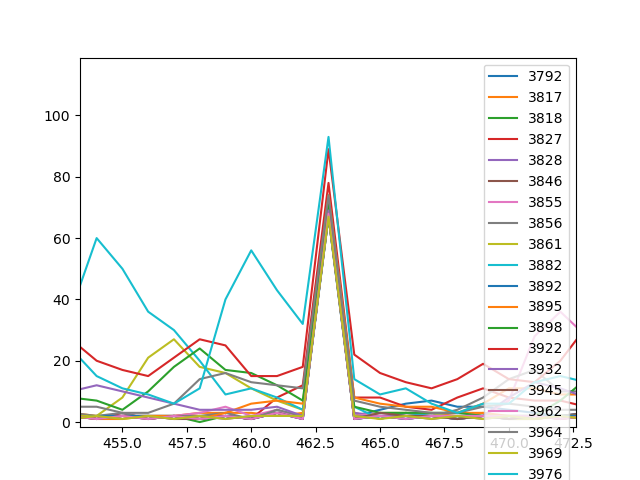

In [100]:
#Examining single pulses

import random

currentPulse = random.randrange(len(pulseIndexes))
pulsesToPlot = 20

%matplotlib notebook
wierdPulses = dfPulses.iloc[pulseIndexes[currentPulse:currentPulse + pulsesToPlot]]

wierdPulses[wierdPulses.columns[:PMT_PULSE_LENGTH]].T.plot()
plt.show()

## Examining single (random) pulses from the original dataset. Looking for abnormality at sample #590

<IPython.core.display.Javascript object>


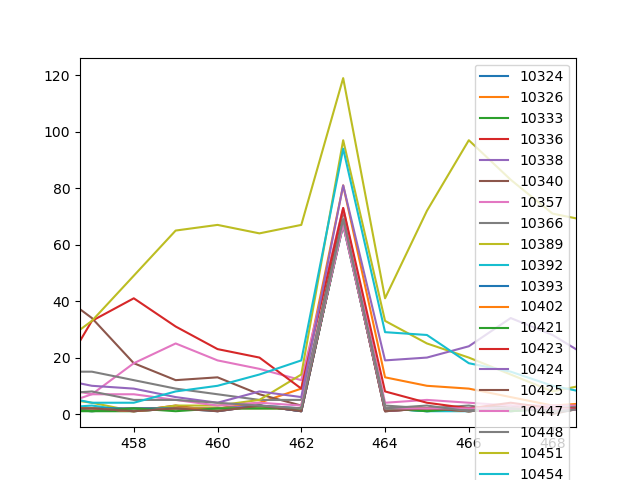

In [101]:
#Comparing with whole dataset (not only wierd puluses)

import random

currentPulse = random.randrange(len(dfPulses))
pulsesToPlot = 20

%matplotlib notebook
dfPulses.iloc[currentPulse:currentPulse + pulsesToPlot][dfPulses.columns[:PMT_PULSE_LENGTH]].T.plot()

plt.show()